In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from qbstyles import mpl_style
from datetime import datetime as pdt
import numpy as np

In [107]:
!mkdir "csv"
# Todo reminder here that you could also use the dt.today() funtion
dateRange = pd.date_range('04-12-2020', '08-13-2021')
for date in dateRange:
    datestr = date.strftime('%m-%d-%Y')
    !curl {"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/" + datestr + ".csv"} -o {"csv/" + datestr + ".csv"}
    

 Left  Speed
100  542k  100  542k    0     0   9.8M      0 --:--:-- --:--:-- --:--:--  9.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542k  100  542k    0     0  5959k      0 --:--:-- --:--:-- --:--:-- 5959k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542k  100  542k    0     0  7861k      0 --:--:-- --:--:-- --:--:-- 7861k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542k  100  542k    0     0  5479k      0 --:--:-- --:--:-- --:--:-- 5479k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542k  100  542k    0     0  9353k 

In [3]:
# Starting with US first
dateRange = pd.date_range('04-12-2020', '08-13-2021')
us_data, pa_data, mont_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for date in dateRange:
    df = pd.read_csv('csv/' + date.strftime('%m-%d-%Y') + '.csv')[['FIPS','Province_State','Country_Region','Confirmed']]
    us_df = df.query('Country_Region == "US"')
    us_df = us_df.groupby('Country_Region').aggregate({'FIPS':max,
                                            'Province_State':max,
                                            'Confirmed':sum})

    pa_df = df.query('Country_Region == "US" and Province_State == "Pennsylvania"')
    pa_df = pa_df.groupby('Province_State').aggregate({'FIPS':max,
                                            'Country_Region':max,
                                            'Confirmed':sum})
    mont_df = df.query('FIPS == 42091') # Code for PA Montgom County
    if us_data.empty:
        us_data = us_df
        pa_data = pa_df
        mont_data = mont_df      
    else:
        us_data = pd.concat((us_data,us_df), ignore_index=True)
        pa_data = pd.concat((pa_data,pa_df), ignore_index=True)
        mont_data = pd.concat((mont_data,mont_df), ignore_index=True)

us_data.index = dateRange; pa_data.index = dateRange; mont_data.index = dateRange


In [4]:
us_data = us_data[['Confirmed']]; pa_data = pa_data[['Confirmed']]; mont_data = mont_data[['Confirmed']]

for data_set in [us_data, pa_data, mont_data]:
    prev = 0
    new_cases = []
    for row in data_set.iterrows():        
        ind = row[1].loc['Confirmed']
        new_cases.append(ind - prev)
        prev = ind
    data_set['New_Cases'] = pd.DataFrame({'New_Cases':new_cases}, index=dateRange)

# The first of the Cases Per Day should be 0 since that is our starting point
us_data.loc['04-12-2020','New_Cases'] = 0; pa_data.loc['04-12-2020','New_Cases'] = 0; mont_data.loc['04-12-2020','New_Cases'] = 0
mont_data

,Confirmed,New_Cases
2020-04-12,2164,0
2020-04-13,2285,121
2020-04-14,2354,69
2020-04-15,2475,121
2020-04-16,2544,69
...,...,...
2021-08-09,72313,212
2021-08-10,72435,122
2021-08-11,72528,93
2021-08-12,72653,125


# OK, big problem was that setting a time series and then using a barplot quickly screws everything up

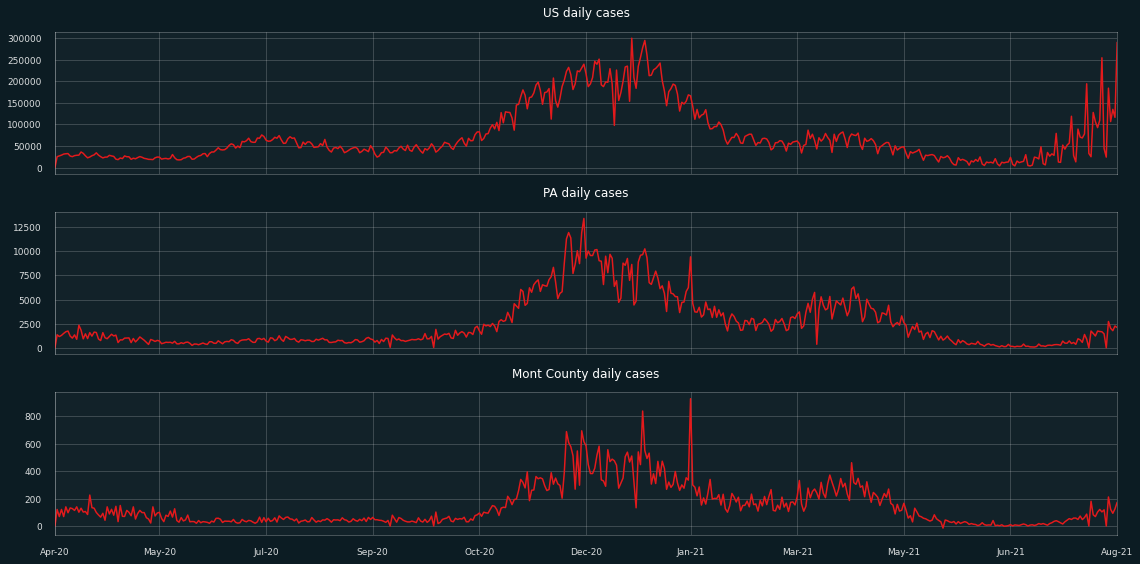

In [42]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(16,8), sharex=True)

xticks = pd.date_range(dateRange[0], dateRange[-1], periods=11)
xlabels = [i.strftime('%b-%y') for i in t]

us_data.plot(y='New_Cases',ax=ax[0], legend=False, title='US daily cases')
pa_data.plot(y='New_Cases',ax=ax[1], legend=False, title='PA daily cases')
mont_data.plot(y='New_Cases',ax=ax[2], legend=False, title='Mont County daily cases')

ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xlabels)

fig.tight_layout()


In [30]:
xticks = pd.date_range(dateRange[0], dateRange[-1], periods=11)
xlabels = [i.strftime('%b-%y') for i in t]
x

['Apr-20',
 'May-20',
 'Jul-20',
 'Sep-20',
 'Oct-20',
 'Dec-20',
 'Jan-21',
 'Mar-21',
 'May-21',
 'Jun-21',
 'Aug-21']